# Photometry module

The aim of this module is to take reduced images produced from the last module and measure fluxes for astrophysical targets in the image. This process is known as photometry, and involves calibration of the images to derive a relationship between the counts in the image and brightness on the sky. The instrumental and physical magnitudes on the sky are related by a quantity known as the Zero-point (ZP), which we need to derive from the image. We will cover two main approaches to measures fluxes in the image:

- Aperture photometry
- Point spread function (PSF) photometry

Both these methods have their own advantages and limitations, and we will discuss these aspects over the course of the module.

Let's start by importing a few necessary modules first.

In [1]:
import numpy as np
import numpy.ma as ma
import os
import astropy.units as u
from astropy.io import ascii
from astropy.coordinates import SkyCoord
from astropy.wcs import WCS
from astropy.stats import sigma_clipped_stats, sigma_clip

Let's plot a reduced image from the previous module.

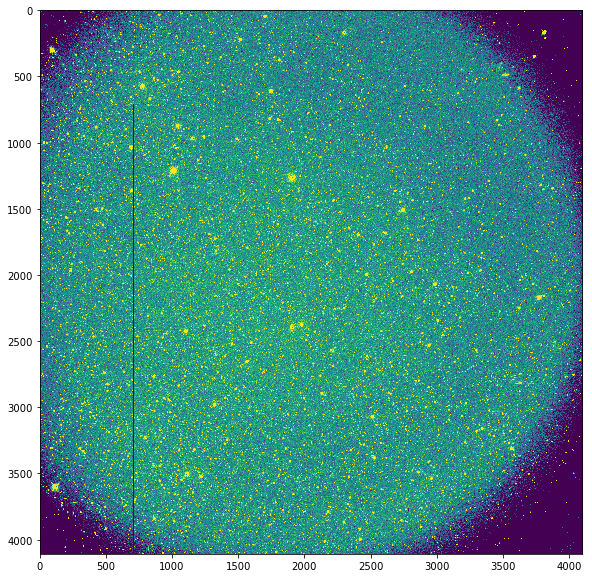

In [2]:
from astropy.io import fits
import matplotlib.pyplot as plt

imageName = 'aC0_20181013-174714-557.wcs.fits.proc.cr.fits'
f = fits.open(imageName)
data = f[0].data  #This is the image array
header = f[0].header

#Compute some image statistics for scaling the image plot
mean, median, sigma = sigma_clipped_stats(data)

#plot the image with some reasonable scale
plt.figure(figsize=(10,10))
plt.imshow(data, vmin=median-3*sigma, vmax=median+3*sigma)
plt.show()

## Querying an external catalog

The first step is to obtain the known magnitudes of sources in the field in order to subsequently compare them to the measured instrumental magnitudes. We thus have to refer to some external catalog for sources in the field.  For this tutorial, we will refer the Panstarrs 1 (PS1) catalog. We will query PS1 using astropy's query interface _astroquery_ to query the Vizier server and get a list of sources. First, we have to know the coordinates of the center of this field from the image header.

In [3]:
#strong the image WCS into an object
w = WCS(header)

#Get the RA and Dec of the center of the image
[raImage, decImage] = w.all_pix2world(data.shape[0]/2, data.shape[1]/2, 1)

#Set the box size to search for catalog stars
boxsize = 30 # arcminutes

#Magnitude cut-offs of sources to be cross-matched against
maxmag = 18

Since PS1 is much deeper than a single image from the GROWTH India telescope, we also put a cut-off on the magnitude range of sources we want to calibrate against. For this specific example, a limiting magnitude of 18 mag in g band should suffice. We also want to reject transients and variable sources in PS1 (need a cut-off on the number of detections in the PS1 survey), and only select sources that have $>3 \sigma$ detections in PS1, so we will incorporate those filters into the PS1 query.

In [4]:
from astroquery.vizier import Vizier
#Vizier.VIZIER_SERVER = 'vizier.ast.cam.ac.uk'

catNum = 'II/349'#This is the catalog number of PS1 in Vizier
print('\nQuerying Vizier %s around RA %.4f, Dec %.4f with a radius of %.4f arcmin'%(catNum, raImage, decImage, boxsize))

try:
    #You can set the filters for the individual columns (magnitude range, number of detections) inside the Vizier query
    v = Vizier(columns=['*'], column_filters={"gmag":"<%.2f"%maxmag, "Nd":">6", "e_gmag":"<1.086/3"}, row_limit=-1)
    Q = v.query_region(SkyCoord(ra = raImage, dec = decImage, unit = (u.deg, u.deg)), radius = str(boxsize)+'m', catalog=catNum, cache=False)
    #query vizier around (ra, dec) with a radius of boxsize
    print(Q[0])
except:
    print('I cannnot reach the Vizier database. Is the internet working?')


Querying Vizier II/349 around RA 324.8076, Dec 46.7254 with a radius of 30.0000 arcmin
   RAJ2000       DEJ2000          objID        ...  yKmag  e_yKmag  yFlags 
     deg           deg                         ...   mag     mag           
------------- ------------- ------------------ ... ------- ------- --------
324.546492510  46.264703470 163513245465168323 ... 16.9685  0.0654   115000
324.530625620  46.266287540 163523245306050216 ... 13.9154  0.0091    16696
324.529447350  46.265017540 163513245294518713 ... 14.1221  0.0034   115000
324.538854840  46.274398210 163523245388569962 ... 15.0640  0.0109   115000
324.528015530  46.275544270 163533245280161337 ... 12.3784  0.0305   115000
324.523853150  46.279186790 163533245238505715 ... 16.5256  0.0110   115000
324.516592810  46.283122040 163543245165700413 ... 14.1370  0.0074   115000
324.512081250  46.287262650 163543245120575404 ... 16.7702  0.0450    16696
324.516398520  46.270782360 163523245164085625 ... 15.8548  0.0072   115000


Just in case the Vizier query did not go through (this can happen, depending on the load on the Vizier servers), read in the source table in the file ps1_v641cyg.tab. No need to do this step if your query did go through.

In [ ]:
from astropy.table import Table

Q = [Table.read('ps1_v641cyg.tab')]

print(Q[0])

The query should have retrieved about 10,000 known sources in this field. We will now filter stars that are away from the edges of the image (same as in the case of the SExtractor detected sources). Note that you can also put additional filters in the catalog sources by just adding more conditions to the the commands below.

Using the same method as we used to figure out the center of the image, use the catalog coordinates from the astropy table to get image coordinates of the sources. Then create a table called good_cat_stars to only store stars that within the pixel range (500, 3500) in both x and y directions in the image.

In [5]:
#Convert the world coordinates of these stars to image coordinates
ps1_imCoords = w.all_world2pix(Q[0]['RAJ2000'], Q[0]['DEJ2000'], 1)

#Another round of filtering where we reject sources close to the edges
good_cat_stars = Q[0][np.where((ps1_imCoords[0] > 500) & (ps1_imCoords[0] < 3500) & (ps1_imCoords[1] > 500) & (ps1_imCoords[1] < 3500))]
print(good_cat_stars)

   RAJ2000       DEJ2000          objID        ...  yKmag  e_yKmag yFlags
     deg           deg                         ...   mag     mag         
------------- ------------- ------------------ ... ------- ------- ------
324.991321070  46.493072460 163793249913192336 ... 15.6587  0.0080 115000
324.995456660  46.491872990 163793249954760916 ... 16.4147  0.0169 115000
324.996154600  46.493197980 163793249960252496 ... 16.6141  0.0074 115000
324.986133270  46.486829770 163783249861224813 ... 16.2165  0.0097 115000
324.990104900  46.484038270 163783249901031502 ... 16.5208  0.0107 115000
324.975856910  46.479822180 163773249758666438 ... 16.0091  0.0101  16696
324.987516640  46.482068620 163773249875209155 ... 15.9656  0.0123 115000
325.029065080  46.500275900 163803250289711054 ... 13.0745  0.0052 115000
325.005109120  46.502755980 163803250051153972 ... 14.2958  0.0108 115000
325.012635110  46.507884270 163813250126600147 ... 16.3732  0.0091 115000
          ...           ...           

Let's get the image coordinates of the filtered good catalog stars and plot them on the image.

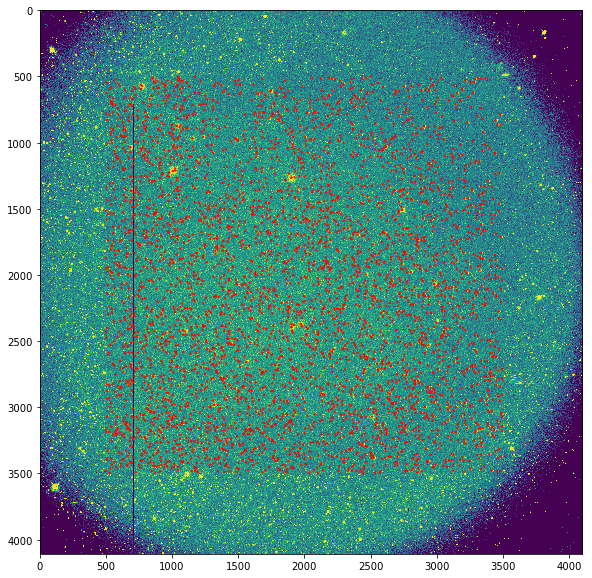

In [6]:
ps1_imCoords = w.all_world2pix(good_cat_stars['RAJ2000'],good_cat_stars['DEJ2000'], 1)

fig = plt.figure(figsize=(10,10))
ax = fig.gca()
plt.imshow(data, vmin=median-3*sigma, vmax=median+3*sigma)
circles = [plt.Circle((ps1_imCoords[0][i], ps1_imCoords[1][i]), radius = 5, edgecolor='r', facecolor='None') for i in range(len(ps1_imCoords[0]))]
for c in circles:
    ax.add_artist(c)
    
plt.show()

## Aperture photometry

To start with aperture photometry, we have to identify point sources in this image and compare their brightness to a known catalog. We will use a popular code known as 'Source Extractor' (a.k.a. SExtractor) to detect point sources in the image.

### Source detection

SExtractor is a very powerful code, and can do a large range of complex source detection tasks, but needs to be appropriately configured via its configuration and parameter file to specify the kind of sources we want to detect and the parameters we want to measure.

In this case, you have a configuration file available in the directory designed to detect sources above a 10$\sigma$ threshold from the background and measure it's flux. We'll go over the details, but let's see how SExtractor runs first.

In [7]:
import subprocess
configFile = 'photomCat.sex'
catalogName = imageName+'.cat'
paramName = 'photomCat.param'
try:
    rval = subprocess.run(['sex', '-c', configFile, imageName, '-CATALOG_NAME', catalogName, '-PARAMETERS_NAME', paramName], check=True)
except subprocess.CalledProcessError as err:
    print('Could not run sextractor with exit error %s'%err)

Here, we are running SExtractor with a configuration file specified with the '-c' flag and asking it to output the list of sources it deteced to a file called imageName+'.cat' in a format known as the FITS LDAC. The ouput parameters to be produced by SExtractor are in the file 'photomCat.param' and specified by the flag 'PARAMETERS_NAME'. We will now read in the source catalog produced by SExtractor into an astropy table. Before that, here is a function to read FITS LDAC tables with astropy.

In [8]:
def get_table_from_ldac(filename, frame=1):
    """
    Load an astropy table from a fits_ldac by frame (Since the ldac format has column 
    info for odd tables, giving it twce as many tables as a regular fits BinTableHDU,
    match the frame of a table to its corresponding frame in the ldac file).
    
    Parameters
    ----------
    filename: str
        Name of the file to open
    frame: int
        Number of the frame in a regular fits file
    """
    from astropy.table import Table
    if frame>0:
        frame = frame*2
    tbl = Table.read(filename, hdu=frame)
    return tbl

In [9]:
#This is a python wrapper for reading LDAC files produced by SExtractor
sourceTable = get_table_from_ldac(catalogName)
#Let's look at the contents of the table
print(sourceTable.colnames)
print(sourceTable)

['VIGNET', 'X_IMAGE', 'Y_IMAGE', 'XWIN_IMAGE', 'YWIN_IMAGE', 'ERRAWIN_IMAGE', 'ERRBWIN_IMAGE', 'ALPHAWIN_J2000', 'DELTAWIN_J2000', 'FLUX_RADIUS', 'FWHM_WORLD', 'FLUX_AUTO', 'FLUXERR_AUTO', 'SNR_WIN', 'ELONGATION', 'FLUX_MAX', 'MAG_AUTO', 'MAGERR_AUTO', 'FLAGS', 'BACKGROUND', 'CLASS_STAR', 'FLUX_APER', 'FLUXERR_APER', 'MAG_APER', 'MAGERR_APER']
       VIGNET [27,27]        X_IMAGE   ...        MAGERR_APER [10]       
             ct                pix     ...              mag              
--------------------------- ---------- ... ------------------------------
     6.4226837 .. 23.857485  1701.0402 ... 0.00016702044 .. 0.00022828423
    -5.962967 .. -12.014122   900.8122 ...  0.00044055126 .. 0.0006496695
      -67.4418 .. -68.55728  3444.9138 ...   0.0018794023 .. 0.0025058936
     -81.50293 .. -73.63473  308.45758 ...    0.0035672889 .. 0.006773806
       0.70864487 .. -1e+30  1060.0299 ...       0.016923694 .. 0.0244867
       -1e+30 .. -38.968838  402.49585 ...   0.0010504833 .. 0

Note the columns in the output table -- important ones are 'XWIN_IMAGE' and 'YWIN_IMAGE' that are the centroids of the detected stars in image coordinates while 'ALPHAWIN_J2000' and 'DELTAWIN_J2000' are the same in world coordinates. We also have the background subtracted flux of the sources measured in fixed apertures ('FLUX_APER') and the magnitudes in fixed apertures ('MAG_APER').

In order to derive a good photometric solution, we want to find 'clean' sources that are not blended with other objects and are away from the edges of the image, and get their instrumental magnitudes. The SExtractor output has a 'FLAGS' column that indicates unblended sources away from bad pixels with FLAGS = 0 (read the SExtractor manual to find out what other values of the flags mean). In order to get point-like sources, we also want the FWHM of the source to be smaller than about 2 arc seconds that are away from the edges of the image. So let's select the sources that satisfy this condition.

In [10]:
#filter on the sources to select the ones satisfying our criteria
cleanSources = sourceTable[(sourceTable['FLAGS']==0) & (sourceTable['FWHM_WORLD'] < 2) & (sourceTable['XWIN_IMAGE']<3500) & (sourceTable['XWIN_IMAGE']>500) &(sourceTable['YWIN_IMAGE']<3500) &(sourceTable['YWIN_IMAGE']>500)]
print(cleanSources)

       VIGNET [27,27]        X_IMAGE   ...       MAGERR_APER [10]      
             ct                pix     ...             mag             
--------------------------- ---------- ... ----------------------------
   0.40839386 .. -8.4237175   1175.243 ...   0.005133717 .. 0.007540144
     19.195414 .. 1.6245003   858.6505 ... 0.0012831761 .. 0.0018891117
   -1.4393997 .. -1.9915695  2187.9465 ...  0.0028351247 .. 0.004148845
    -10.872696 .. 7.5240746    2469.36 ...   0.006484255 .. 0.009521742
     -6.925556 .. -8.525333  2503.7578 ...    0.016805736 .. 0.02316465
   -3.559719 .. -0.62106705  3035.4197 ...   0.008535756 .. 0.012065269
    16.819191 .. -0.6012573  2208.2244 ... 0.0020246268 .. 0.0029673914
     -10.6077385 .. 9.01561  2436.8604 ...  0.004062045 .. 0.0059486763
    -4.077919 .. 0.22921753  2125.2761 ...  0.0046641687 .. 0.006761822
     24.304968 .. 5.9036026  969.05255 ... 0.0009709019 .. 0.0014186793
                        ...        ... ...                      

Now overlay these detected sources on the reduced image to see how sextractor performed

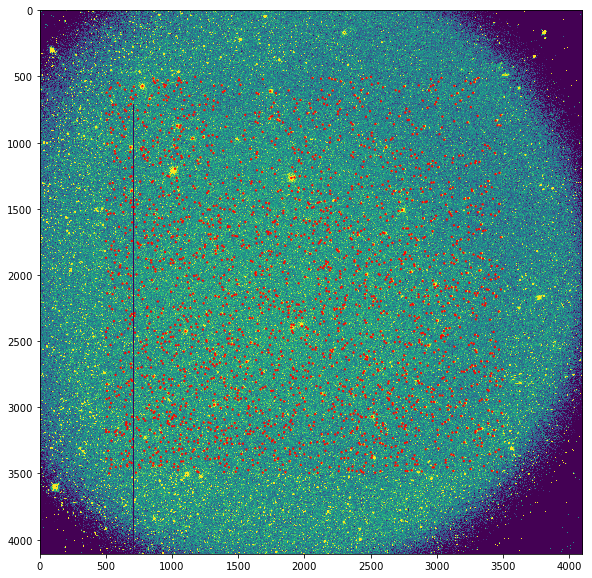

In [11]:
fig = plt.figure(figsize=(10,10))
ax = fig.gca()
plt.imshow(data, vmin=median-3*sigma, vmax=median+3*sigma)
#plotting circles on top of all detected sources
circles = [plt.Circle((source['XWIN_IMAGE'], source['YWIN_IMAGE']), radius = 5, edgecolor='r', facecolor='None') for source in cleanSources]
for c in circles:
    ax.add_artist(c)


plt.show()

### Catalog cross-matching

So far, we have the catalog of sources detected in the image, and an external catalog of sources we want to compare against. The next step is to cross-match the two catalogs and find associations between sources detected in the image and sources on the sky.

In [12]:
sourceCatCoords = SkyCoord(ra=cleanSources['ALPHAWIN_J2000'], dec=cleanSources['DELTAWIN_J2000'], frame='icrs', unit='degree')
ps1CatCoords = SkyCoord(ra=good_cat_stars['RAJ2000'], dec=good_cat_stars['DEJ2000'], frame='icrs', unit='degree')

#Now cross match sources

#Set the cross-match distance threshold to 0.6 arcsec, or just about one pixel
photoDistThresh = 0.6
idx_image, idx_ps1, d2d, d3d = ps1CatCoords.search_around_sky(sourceCatCoords, photoDistThresh*u.arcsec)
#idx_image are indexes into sourceCatCoords for the matched sources, while idx_ps1 are indexes into ps1CatCoords for the matched sources

print('Found %d good cross-matches'%len(idx_image))

Found 748 good cross-matches


### Zero-point derivation

Now that we have cross-matched sources between the image and PS1, we can start deriving zero-points. Recall that the instrumental magnitude of a source is related to its physical magnitude via the zero-point relation

<h2> <center>

$m_{app}$ = ZP + $m_{ins}$ <br><br>

$m_{ins} = -2.5 \, \textrm{log} \, (\textrm{Total flux})$

</center></h2>

It should be easy to see that the instrumental magniutde of a source depends on the way you measure the flux, and this is exactly where the different ways of photometry come into play.

As we've already discussed, aperture photometry involves measuring the flux of a source in a fixed aperture of some radius. The amount of flux you measure is also dependent on the size of the aperture you choose. The larger the aperture, the more flux you capture from the wings of the PSF. At the same time, a larger aperture might also have contamination from neighboring sources, so you have to be careful.

In order to be consistent with flux measurements of your catalog calibrators and your target, you have to measure fluxes in the same apertures so that you are 'missing' the same fraction of flux between your calibrators and target source. As the zero-point depends on the difference between the catalog and instrumental magnitudes, the zero-point you derive will also be a function of the size of the aperture you choose -- so an aperture specific zero-point will allow us to account for these issues. Let's see an example of this.

The SExtractor catalogs we got from the image actually also contains aperture photometry for the detected sources in the 'MAG_APER' keyword, so most of our work is actually already done. In this case, the SExtractor parameter file already specified the diameter of the apertures we wanted to measure: 4.0 pixels to 13.0 pixels in steps of 1.0 pixel. 

__Exercise__: Go ahead and look at the SExtractor configuration file and find where these apertures are specified.

To see how the measured instrumental magnitude changes between apertures of different sizes, we can plot the differences between the magnitude measured in the largest aperture (13.0 pixels) and every other aperture and plot the differences. 

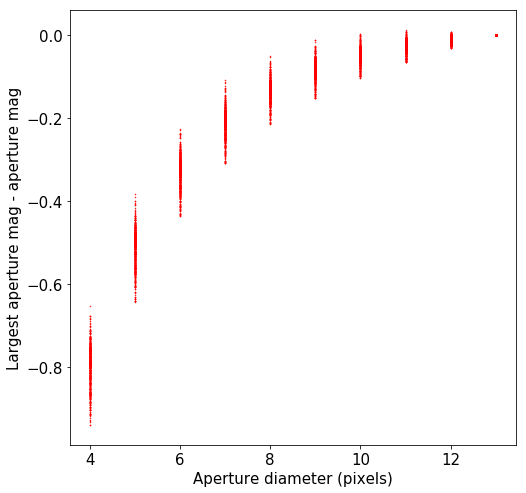

In [13]:
#Apertures in the SExtractor configuration file
aperture_diameter = np.arange(4, 14)

#For each aperture, we are going to compute the magniutde difference between the largest pixel aperture and that specific aperture for every source in cross-matched catalog
magDiff = np.ma.zeros((len(aperture_diameter), len(idx_image)))
for j in range(len(aperture_diameter)):
    magDiff[j] = sigma_clip(cleanSources['MAG_APER'][:,9][idx_image] - cleanSources['MAG_APER'][:,j][idx_image])
#Here, magDiff is a 2D array contaning the difference magnitudes for each source and aperture
    
#Now, let's plot the magnitude differences 
plt.figure(figsize = (8,8))
plt.plot(aperture_diameter, magDiff, 'r.', markersize=1)
plt.xlabel('Aperture diameter (pixels)', fontsize=15)
plt.ylabel('Largest aperture mag - aperture mag', fontsize = 15)
plt.xticks(fontsize = 15)
plt.yticks(fontsize = 15)
plt.show()

As apparent, the magnitudes become systematically fainter for smaller apertures. Recall that the larger the aperture, the more flux and the lower magnitude. This curve is often called as the __Curve of Growth__.

Now, let's overplot the instrumental (for any given aperture) and PS1 magnitudes for the good cross-matched sources.

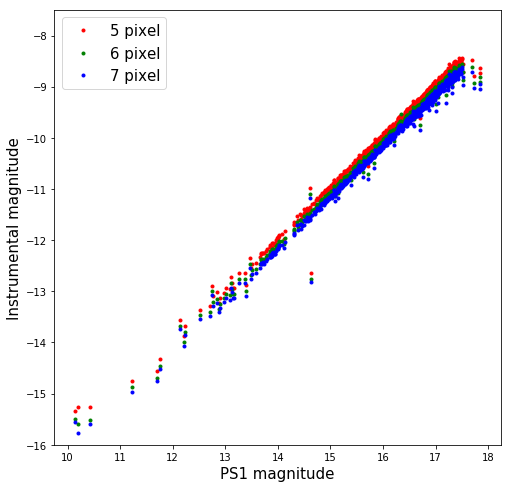

In [14]:
plt.figure(figsize=(8,8))
#Plotting instrumental magnitude for aperture sizes of 5.0, 6.0 and 7.0 pixels
plt.plot(good_cat_stars['gmag'][idx_ps1], cleanSources['MAG_APER'][:,2][idx_image] , 'r.', label='5 pixel')
plt.plot(good_cat_stars['gmag'][idx_ps1], cleanSources['MAG_APER'][:,3][idx_image] , 'g.', label='6 pixel')
plt.plot(good_cat_stars['gmag'][idx_ps1], cleanSources['MAG_APER'][:,4][idx_image] , 'b.', label='7 pixel')
plt.ylim(-16, -7.5)
plt.xlabel('PS1 magnitude', fontsize=15)
plt.ylabel('Instrumental magnitude', fontsize=15)
plt.legend(fontsize=15)
plt.show()

That is a good correlation between the PS1 and instrumental magnitudes, also showing the small systematic offsets between the magnitudes of different aperture sizes. 

We are ready to derive a zero-point for each aperture. From the earlier equation, the zero-point is just the difference between the catalog and instrumental magnitudes, so we want to measure the average offset between these magnitudes, including rejection of bad outliers that might affect the photometry. The results will be stored in an array of dictionaries containing the mean, median and standard deviation of the zero-point.

In [15]:
zeroPoints = []
for i in range(len(aperture_diameter)):
    #Array of differences between the catalog and instrumental magnitudes
    offsets = ma.array(good_cat_stars['gmag'][idx_ps1] - cleanSources['MAG_APER'][:,i][idx_image])
    #Compute sigma clipped statistics
    zero_mean, zero_med, zero_std = sigma_clipped_stats(offsets)
    zeroDict = {'diameter': aperture_diameter[i], 'zp_mean': zero_mean, 'zp_median': zero_med, 'zp_std': zero_std}
    zeroPoints.append(zeroDict)
    print(zeroDict)

{'diameter': 4, 'zp_mean': 25.4901364074112, 'zp_median': 25.488113817596435, 'zp_std': 0.03652963177200057}
{'diameter': 5, 'zp_mean': 25.77510534704299, 'zp_median': 25.77419780578613, 'zp_std': 0.03533955618232879}
{'diameter': 6, 'zp_mean': 25.957074592276115, 'zp_median': 25.956391754150392, 'zp_std': 0.03510991994317377}
{'diameter': 7, 'zp_mean': 26.075167255174676, 'zp_median': 26.076413306427003, 'zp_std': 0.03660146731678469}
{'diameter': 8, 'zp_mean': 26.15185565730967, 'zp_median': 26.153427323913576, 'zp_std': 0.038785139409337484}
{'diameter': 9, 'zp_mean': 26.20309040569057, 'zp_median': 26.20499310302734, 'zp_std': 0.04199860536407131}
{'diameter': 10, 'zp_mean': 26.237357219375824, 'zp_median': 26.239008388519288, 'zp_std': 0.04659602723581701}
{'diameter': 11, 'zp_mean': 26.261192700036503, 'zp_median': 26.262815995788575, 'zp_std': 0.050839020837056936}
{'diameter': 12, 'zp_mean': 26.27708224853516, 'zp_median': 26.279197425842284, 'zp_std': 0.054368917650005524}
{'d

As apparent, the zero-point changes with the size of the aperture. So, when you want to derive photometry, you should measure fluxes in an aperture and apply the zero-point correction for the same aperture to get accurate photometry. This correction for the aperture size is known as an __Aperture correction__. Now, let's do some photometry on our favorite object with pyraf!

In [16]:
from pyraf import iraf
from iraf import noao, digiphot, apphot


No graphics display available for this session.
Graphics tasks that attempt to plot to an interactive screen will fail.
For help, search "PyRAF FAQ 5.13" or contact "help@stsci.edu".



We can now directly measure the flux of our favorite source in a fixed aperture, apply the zero-point correction for that aperture and get it's physical magnitude. Since the aperture-based zero points already include the effect of varying flux due to different aperture sizes, the magnitudes measured for different apertures should be consistent with each other. However, it can be shown that the aperture size that maximizes the signal-to-noise ratio of a measurement is such that it's radius is approximately equal to the FWHM of the source in the image.

In [17]:
#Radii of the apertures to measure magnitudes in
apRadii = aperture_diameter/2
apString = ",".join([str(x) for x in apRadii])

#Setting the radius and width and annulus to measure the background
anuRadius = 14./2
anuWidth = 6./2

#Coordinates of V641 Cyg
ra = 324.7915750
dec = 46.7254686

#Write the coordinates to a file for IRAF to read in
outCoordName = 'coords.txt'
g = open('coords.txt', 'w')
g.write('%.5f\t%.5f\n'%(ra, dec))
g.close()

#Start aperture photometry
apphot.unlearn()

#Setup the parameters of the photometry
medFWHM = np.median(cleanSources['FWHM_WORLD'][idx_image])
print('The median FWHM in the image is %.2f arcsec'%(medFWHM*3600))

apphot.fitskypars.annulus = anuRadius
apphot.fitskypars.dannulu = anuWidth
apphot.photpars.aperture = apString

magFile = imageName + '.apermag.txt'
apphot.phot(image = imageName, coords = outCoordName, interactive = 'no', wcsin = 'world', verify='no', output=magFile)


The median FWHM in the image is 2.46 arcsec


We will read in the magnitudes measured by IRAF, apply the respective zero-point corrections and compute uncertainties by adding the measured magnitude uncertainties and zero-point uncertainties in quadrature.

In [18]:
compMagList = ascii.read(magFile, format = 'no_header', data_start=4)

radii = compMagList['col1']
fluxSums = compMagList['col2']
fluxArea = compMagList['col3']
flux = compMagList['col4']
mags = compMagList['col5']
magErrs = compMagList['col6']

for i in range(len(mags)):
    magCorrected = mags[i] + zeroPoints[i]['zp_median'] - 25
    #IRAF assumes a zero-point of 25 by default, so we've adjusted for that offset here
    magCorrectedErr = np.sqrt(zeroPoints[i]['zp_std']**2 + magErrs[i]**2)
    print('Corrected magnitude of %.2f +/- %.2f for a diameter of %.1f pixels'%(magCorrected, magCorrectedErr, zeroPoints[i]['diameter']))

Corrected magnitude of 14.97 +/- 0.04 for a diameter of 4.0 pixels
Corrected magnitude of 14.97 +/- 0.04 for a diameter of 5.0 pixels
Corrected magnitude of 14.98 +/- 0.04 for a diameter of 6.0 pixels
Corrected magnitude of 14.99 +/- 0.04 for a diameter of 7.0 pixels
Corrected magnitude of 14.99 +/- 0.04 for a diameter of 8.0 pixels
Corrected magnitude of 14.99 +/- 0.04 for a diameter of 9.0 pixels
Corrected magnitude of 15.00 +/- 0.05 for a diameter of 10.0 pixels
Corrected magnitude of 15.00 +/- 0.05 for a diameter of 11.0 pixels
Corrected magnitude of 15.00 +/- 0.05 for a diameter of 12.0 pixels
Corrected magnitude of 15.00 +/- 0.06 for a diameter of 13.0 pixels


Note that the aperture photometry magnitudes are completely consistent with each other within the errors of the measurements (the physical magnitude of a source should not depend on the aperture you used to measure the flux), suggesting that the aperture corrections worked fine. Also note that the errors become progressively larger for large apertures since we are accumulating more noise from the background. 

__Question__ : Can you think of another way we could have obtained by the aperture photomtery magnitude for this source? Think of what was contained in the SExtractor catalogs -- how would you extract the magnitudes for the source from the SExtractor catalog?

## PSF Photometry

Aperture photometry is fairly straightforward and works well for sources that are relatively isolated (there are no other sources in the aperture or the background). However, this may not be the case for sources in crowded fields (e.g. the galactic plane), where finding a source-free aperture can be difficult. This is where PSF photometry comes in.

### Creating a PSF model

The idea behind PSF photometry is to create a model for the Point Spread Function of stars in the field by fitting a large number of stars. The models are then iteratively subtracted from the data and refined to minimize the residuals. There are a number of PSF photometry packages in use today, with varying degrees of manual innvolvement and automation. For this module, we will use a package known as PSFEx, also from the Astromatic set of codes. 

PSFEx takes a SExtractor catalog as input. The catalog should be in the FITS LDAC format and contain cut-outs of the detected stars in the field, on which it performs the model fitting. For this module, we actually already produced the star cut-outs when we ran SExtractor the first time -- the 'PARAMETERS_NAME' file had an entry called VIGNET, specifying the size of the cut-out around each star. We will now run PSFEx on this catalog and try to produce a PSF model for the image. We again have an input configuration file called 'psfex_conf.psfex' that specified the run-time parameters for PSFEx.

In [19]:
psfConfigFile = 'psfex_conf.psfex'
try:
    rval = subprocess.run(['psfex', '-c', psfConfigFile, catalogName], check=True)
except subprocess.CalledProcessError as err:
    print('Could not run psfex with exit error %s'%err)

Now plot the PSF model produced by PSFEx. The best-fit Moffat model is stored as a FITS file in the output image 'moffat_' + imageName + '.fits'.

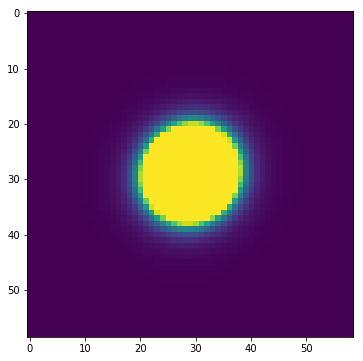

In [20]:
psfModelHDU = fits.open('moffat_'+imageName+'.fits')[0]
psfModelData = psfModelHDU.data
mean, median, std = sigma_clipped_stats(psfModelData)
plt.figure(figsize=(6,6))
plt.imshow(psfModelData, vmin=0, vmax=median+20*std)
plt.show()

It is also instructive to have a look at the radial profile of the best-fit PSF model. Let's make a radial profile and plot it.

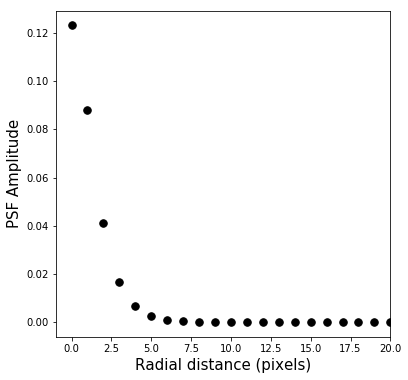

In [21]:
psfImageCenter = [(psfModelData.shape[0]-1)/2, (psfModelData.shape[1]-1)/2]
y, x = np.indices(psfModelData.shape)
r = np.sqrt((x-psfImageCenter[0])**2 + (y-psfImageCenter[1])**2)
r = r.astype(np.int)

tbin = np.bincount(r.ravel(), psfModelData.ravel())
nr = np.bincount(r.ravel())
radialprofile = tbin/nr

plt.figure(figsize=(6,6))
plt.plot(range(len(radialprofile)), radialprofile, 'k.', markersize=15)
plt.xlabel('Radial distance (pixels)', fontsize=15)
plt.ylabel('PSF Amplitude', fontsize=15)
plt.xlim(-1,20)
plt.show()

__Question__: Figure out why the above code is able to produce the radial profile of the PSF.

### Computing PSF-fit photometry for point sources

We can now feed this PSF model back to SExtractor to make it perform PSF model fitting on each of the detected sources and produce PSF-fit fluxes for each source. The full PSF model is stored in a file called imageName + '.psf'. This can take a bit of time depending on how fast your machine is.

In [22]:
psfName = imageName + '.psf'
psfcatalogName = imageName+'.psf.cat'
psfparamName = 'photomPSF.param' #This is a new set of parameters to be obtained from SExtractor, including PSF-fit magnitudes
try:
    #We are supplying SExtactor with the PSF model with the PSF_NAME option
    rval = subprocess.run(['sex', '-c', configFile, imageName, '-CATALOG_NAME', psfcatalogName, '-PSF_NAME', psfName, '-PARAMETERS_NAME', psfparamName], check=True)
except subprocess.CalledProcessError as err:
    print('Could not run sextractor with exit error %s'%err)

Let's read in the new PSF-fit SExtractor catalog as before and check it's contents. You should find additional new columns like 'MAG_POINTSOURCE' and 'MAGERR_POINTSOURCE' -- these are the new PSF model fit magnitudes measured with SExtractor.

In [23]:
psfsourceTable = get_table_from_ldac(psfcatalogName)
#Let's look at the contents of the table
print(psfsourceTable.colnames)
print(psfsourceTable)

['VIGNET', 'X_IMAGE', 'Y_IMAGE', 'XWIN_IMAGE', 'YWIN_IMAGE', 'ERRAWIN_IMAGE', 'ERRBWIN_IMAGE', 'ALPHAWIN_J2000', 'DELTAWIN_J2000', 'FLUX_RADIUS', 'FWHM_WORLD', 'FLUX_AUTO', 'FLUXERR_AUTO', 'SNR_WIN', 'ELONGATION', 'FLUX_MAX', 'MAG_AUTO', 'MAGERR_AUTO', 'FLAGS', 'BACKGROUND', 'CLASS_STAR', 'FLAGS_MODEL', 'NITER_MODEL', 'XMODEL_IMAGE', 'YMODEL_IMAGE', 'FLUX_POINTSOURCE', 'FLUXERR_POINTSOURCE', 'MAG_POINTSOURCE', 'MAGERR_POINTSOURCE', 'FLUXRATIO_POINTSOURCE', 'FLUXRATIOERR_POINTSOURCE']
       VIGNET [27,27]        X_IMAGE   ... FLUXRATIOERR_POINTSOURCE
             ct                pix     ...                         
--------------------------- ---------- ... ------------------------
     6.4226837 .. 23.857485  1701.0402 ...                      0.0
    -5.962967 .. -12.014122   900.8122 ...                      0.0
      -67.4418 .. -68.55728  3444.9138 ...                      0.0
     -81.50293 .. -73.63473  308.45758 ...                      0.0
       0.70864487 .. -1e+30  1060.0

We are now ready to repeat effectively the same exercise as before -- compute an image zero-point based on PSF-fitted magnitudes. 'XMODEL_IMAGE' and 'YMODEL_IMAGE' are the centroids of the stars based on the PSF fitting. The 'FLAGS_MODEL' column can be used to find sources where the PSF-fitting photometry did not work well (the flag is set to 0 for good sources). We will repeat the cross-match between the good PSF-fit sources and the PS1 catalog.

In [24]:
#Selecting the clean sources away from image edges as before 
cleanPSFSources = psfsourceTable[(psfsourceTable['FLAGS']==0) & (psfsourceTable['FLAGS_MODEL']==0)  & (psfsourceTable['FWHM_WORLD'] < 2) & (psfsourceTable['XMODEL_IMAGE']<3500) & (psfsourceTable['XMODEL_IMAGE']>500) &(psfsourceTable['YMODEL_IMAGE']<3500) &(psfsourceTable['YMODEL_IMAGE']>500)]

### Catalog cross-matching

As we did before, perform a cross-match between the clean PSF-fit sources and the PS1 catalog

In [25]:
psfsourceCatCoords = SkyCoord(ra=cleanPSFSources['ALPHAWIN_J2000'], dec=cleanPSFSources['DELTAWIN_J2000'], frame='icrs', unit='degree')
#Now cross match sources
#Set the cross-match distance threshold to 0.6 arcsec, or just about one pixel
photoDistThresh = 0.6
idx_psfimage, idx_psfps1, d2d, d3d = ps1CatCoords.search_around_sky(psfsourceCatCoords, photoDistThresh*u.arcsec)

print('Found %d good cross-matches'%len(idx_psfimage))

Found 748 good cross-matches


Now, make a scatter plot of the PSF-fit magnitudes against the PS1 magnitudes for the matched sources

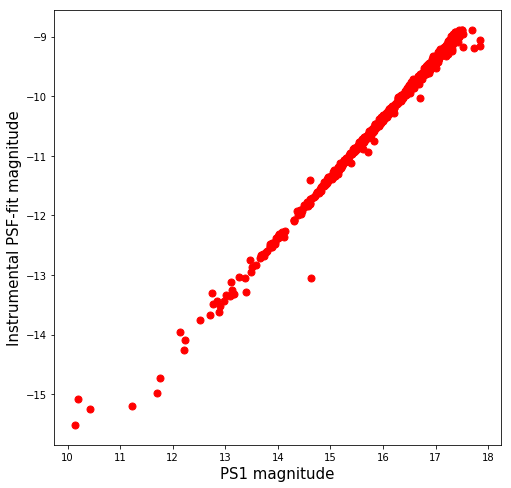

In [26]:
plt.figure(figsize=(8,8))
#Plotting instrumental magnitude for aperture sizes of 5.0, 6.0 and 7.0 pixels
plt.plot(good_cat_stars['gmag'][idx_psfps1], cleanPSFSources['MAG_POINTSOURCE'][idx_psfimage] , 'r.', markersize=14)
#plt.ylim(-16, -7.5)
plt.xlabel('PS1 magnitude', fontsize=15)
plt.ylabel('Instrumental PSF-fit magnitude', fontsize=15)
plt.show()

### Zero-point derivation

Note how the PSF-fit magnitudes deviate from a straight line at the bright end -- this is because the PSF starts becoming saturated on top of very bright stars, leading to poor PSF fits. These will be automatically clipped when we do the 3 sigma clipping for deriving the zero-point. As in the case of aperture photometry, compute a PSF photometry zero-point by sigma-clipping on the offsets between the PSF-fit and PS1 magnitudes. Print the results.

In [27]:
psfoffsets = ma.array(good_cat_stars['gmag'][idx_psfps1] - cleanPSFSources['MAG_POINTSOURCE'][idx_psfimage])
#Compute sigma clipped statistics
zero_psfmean, zero_psfmed, zero_psfstd = sigma_clipped_stats(psfoffsets)
print('PSF Mean ZP: %.2f\nPSF Median ZP: %.2f\nPSF STD ZP: %.2f'%(zero_psfmean, zero_psfmed, zero_psfstd))

PSF Mean ZP: 26.37
PSF Median ZP: 26.37
PSF STD ZP: 0.04


In order to obtain a PSF-fit magnitude for our favorite source, we can directly read off the SExtractor PSF-fit photometry table for the coordinates of our source by cross-matching the table coordinates to the coordinates of our source.

In [28]:
v641cyg_coords = SkyCoord(ra=[ra], dec=[dec], frame='icrs', unit='degree')
idx_v641cyg, idx_cleanpsf_v641cyg, d2d, d3d = psfsourceCatCoords.search_around_sky(v641cyg_coords, photoDistThresh*u.arcsec)
print('Found the source at index %d'%idx_cleanpsf_v641cyg[0])

Found the source at index 1052


Now obtain the PSF-fit magnitude of the source from SExtractor catalog and print the result.

In [29]:
v641cyg_psfinstmag = cleanPSFSources[idx_cleanpsf_v641cyg]['MAG_POINTSOURCE'][0]
v641cyg_psfinstmagerr = cleanPSFSources[idx_cleanpsf_v641cyg]['MAGERR_POINTSOURCE'][0]

v641cyg_psfmag = zero_psfmed + v641cyg_psfinstmag
v641cyg_psfmagerr = np.sqrt(v641cyg_psfinstmagerr**2 + zero_psfstd**2)

print('PSF-fit magnitude of V641 Cyg is %.2f +/- %.2f'%(v641cyg_psfmag, v641cyg_psfmagerr))

PSF-fit magnitude of V641 Cyg is 14.98 +/- 0.04


The aperture-corrected magnitudes and PSF-fit magnitudes should be consistent with each other.